In [23]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


LOAD DATA

In [0]:
import numpy as np
train_data = np.load('/content/drive/My Drive/AIML/Project_FaceDetection/dataset/train.npy', allow_pickle=True)

In [25]:
train_data.shape

(409, 2)

In [0]:
from matplotlib import pyplot as plt


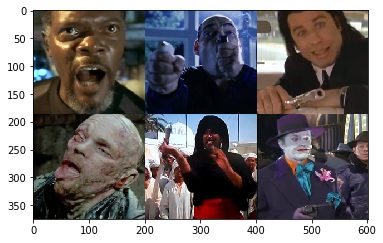

In [27]:
plt.imshow(train_data[69][0], cmap='gray')
plt.show()

In [0]:
y = []
for i in range(len(train_data)):
  y.append(train_data[i][1])

In [29]:
y[0]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

PROCESS DATA AND CREATE MODEL

In [0]:
from keras.applications.mobilenet import MobileNet  
mn_model = MobileNet()

In [0]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam

In [0]:
import tensorflow as tf
def tf_bbox2mask(y1, x1, y2, x2, img_H, img_W):
    ## Repeat for each row or column
    y1_transposed = tf.expand_dims(tf.tile(y1,[img_W]), 0)
    x1_transposed = tf.expand_dims(tf.tile(x1,[img_H]), 1)
    y2_transposed = tf.expand_dims(tf.tile(y2,[img_W]), 0)
    x2_transposed = tf.expand_dims(tf.tile(x2,[img_H]), 1)
    ## Get the range grid
    range_row = tf.cast(tf.expand_dims(tf.range(0, img_H, 1), 1), tf.int32)
    range_col = tf.cast(tf.expand_dims(tf.range(0, img_W, 1), 0), tf.int32)
    ## Generate bollean masks
    mask_y1 = tf.less(y1_transposed, range_row)
    mask_x1 = tf.less(x1_transposed, range_col)
    mask_y2 = tf.less(range_row, y2_transposed)
    mask_x2 = tf.less(range_col, x2_transposed)

    result = tf.to_float(mask_y1)*tf.to_float(mask_x1)*tf.to_float(mask_y2)*tf.to_float(mask_x2)
    return result

In [0]:
mobile = keras.applications.mobilenet.MobileNet()
def prepare_image(img):
    #img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [36]:
base_model=MobileNet(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

17227776/17225924 [==============================] - 0s 0us/step


In [0]:
model=Model(inputs=base_model.input,outputs=preds)

In [0]:
for layer in model.layers[-1:-6]:
    layer.trainable=True

In [0]:
def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
  denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
  return 1 - numerator / denominator

In [0]:
from keras import backend as K
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
  return 1-dice_coef(y_true, y_pred)

In [42]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in dependencies

train_generator=train_datagen.flow_from_directory(train_data,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical'
                                                 shuffle=True)

ValueError: ignored